Load Python Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datasets import Dataset, DatasetDict
!pip install evaluate
import evaluate

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding
)

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix

import torch

print("All libraries loaded successfully.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 5.8 MB/s eta 0:00:00
All libraries loaded successfully.


Load DataSet

In [ ]:

file_path = 'Training_Essay_Data.csv'
df = pd.read_csv(file_path)

import re
def clean_text(text):
    if pd.isna(text): return ""
    return re.sub(r'\s+', ' ', text).strip()

df['text'] = df['text'].apply(clean_text)
df = df[df['text'] != ""]

full_dataset = Dataset.from_pandas(df)

train_test_split_dataset = full_dataset.train_test_split(test_size=0.3, seed=42)

remaining_dataset = train_test_split_dataset['test'].train_test_split(test_size=0.5, seed=42)

dataset_dict = DatasetDict({
    'train': train_test_split_dataset['train'],
    'valid': remaining_dataset['train'],
    'test': remaining_dataset['test']
})

print("Dataset Split: 70% Train, 15% Valid, 15% Test - Done.")
print(dataset_dict)

Dataset Split: 70% Train, 15% Valid, 15% Test - Done.
DatasetDict({
    train: Dataset({
        features: ['text', 'generated'],
        num_rows: 14000
    })
    valid: Dataset({
        features: ['text', 'generated'],
        num_rows: 3000
    })
    test: Dataset({
        features: ['text', 'generated'],
        num_rows: 3000
    })
})


Tokenization

In [ ]:
bert_checkpoint = "bert-base-uncased"
deberta_checkpoint = "microsoft/deberta-v3-small"

tokenizer_bert = AutoTokenizer.from_pretrained(bert_checkpoint)
tokenizer_deberta = AutoTokenizer.from_pretrained(deberta_checkpoint)

def preprocess_bert(examples):
    return tokenizer_bert(examples["text"], truncation=True, padding=True, max_length=512)

def preprocess_deberta(examples):
    return tokenizer_deberta(examples["text"], truncation=True, padding=True, max_length=512)
print("Tokenizing for BERT...")
tokenized_bert = dataset_dict.map(preprocess_bert, batched=True)
print("Tokenizing for DeBERTa...")
tokenized_deberta = dataset_dict.map(preprocess_deberta, batched=True)

tokenized_bert = tokenized_bert.remove_columns(["text"])
tokenized_deberta = tokenized_deberta.remove_columns(["text"])
print("Tokenizations are ready.")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/578 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/convert_slow_tokenizer.py:566: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


Tokenizing for BERT...


Map:   0%|          | 0/14000 [00:00<?, ? examples/s]

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

Tokenizing for DeBERTa...


Map:   0%|          | 0/14000 [00:00<?, ? examples/s]

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

Tokenizations are ready.


In [ ]:

def preprocess_bert(examples):
    # Text-ke token-e rupantor
    result = tokenizer_bert(examples["text"], truncation=True, padding=True, max_length=512)

    result["labels"] = examples["generated"]
    return result

print("Tokenizing with labels, please wait...")
tokenized_bert = dataset_dict.map(preprocess_bert, batched=True)

tokenized_bert = tokenized_bert.remove_columns(["text", "generated"])

print("Now the dataset is ready.")

Tokenizing with labels, please wait...


Map:   0%|          | 0/14000 [00:00<?, ? examples/s]

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

Now the dataset is ready.


BERT

In [ ]:

id2label = {0: "HUMAN", 1: "AI"}
label2id = {"HUMAN": 0, "AI": 1}

model_bert = AutoModelForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=2,
    id2label=id2label,
    label2id=label2id
)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='binary')
    acc = accuracy_score(labels, predictions)

    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

print("BERT Model Setup Completed.")

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BERT Model Setup Completed.


BERT Training Arguments

In [ ]:

data_collator = DataCollatorWithPadding(tokenizer=tokenizer_bert)

training_args = TrainingArguments(
    output_dir="./bert-ai-detection",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    logging_steps=100,
    report_to="none"
)

trainer_bert = Trainer(
    model=model_bert,
    args=training_args,
    train_dataset=tokenized_bert["train"],
    eval_dataset=tokenized_bert["valid"],
    tokenizer=tokenizer_bert,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

print("Training Arguments setup ready.")

Training Arguments setup ready.


/tmp/ipython-input-3102388312.py:21: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_bert = Trainer(


In [ ]:
trainer_bert.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.019700,0.021428,0.995000,0.995012,0.990073,1.000000
2,0.003300,0.144061,0.978000,0.978417,0.957746,1.000000


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.019700,0.021428,0.995000,0.995012,0.990073,1.000000
2,0.003300,0.144061,0.978000,0.978417,0.957746,1.000000
3,0.002600,0.035411,0.995000,0.995012,0.990073,1.000000


TrainOutput(global_step=2625, training_loss=0.020190554152309362, metrics={'train_runtime': 4519.3226, 'train_samples_per_second': 9.293, 'train_steps_per_second': 0.581, 'total_flos': 1.105066432512e+16, 'train_loss': 0.020190554152309362, 'epoch': 3.0})

In [ ]:
print("calculating metrics for BERT on Test Set...")
bert_results = trainer_bert.evaluate(tokenized_bert["test"])

print("\n" + "="*30)
print("BERT PERFORMANCE REPORT")
print("="*30)
print(f"Accuracy  : {bert_results['eval_accuracy']:.4f}")
print(f"Precision : {bert_results['eval_precision']:.4f}")
print(f"Recall    : {bert_results['eval_recall']:.4f}")
print(f"F1 Score  : {bert_results['eval_f1']:.4f}")
print("="*30)

calculating metrics for BERT on Test Set...



BERT PERFORMANCE REPORT
Accuracy  : 0.9947
Precision : 0.9921
Recall    : 0.9974
F1 Score  : 0.9948


DeBERTa

In [ ]:
deberta_checkpoint = "microsoft/deberta-v3-small"
tokenizer_deberta = AutoTokenizer.from_pretrained(deberta_checkpoint)

def preprocess_deberta(examples):
    result = tokenizer_deberta(examples["text"], truncation=True, padding=True, max_length=512)
    result["labels"] = examples["generated"]
    return result

print("Tokenizing for DeBERTa with labels...")
tokenized_deberta = dataset_dict.map(preprocess_deberta, batched=True)

tokenized_deberta = tokenized_deberta.remove_columns(["text", "generated"])

print("DeBERTa Tokenization ready with labels.")

/usr/local/lib/python3.12/dist-packages/transformers/convert_slow_tokenizer.py:566: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


Tokenizing for DeBERTa with labels...


Map:   0%|          | 0/14000 [00:00<?, ? examples/s]

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

DeBERTa Tokenization ready with labels.


DeBERTa Training Arguments

In [ ]:
model_deberta = AutoModelForSequenceClassification.from_pretrained(
    deberta_checkpoint,
    num_labels=2,
    id2label=id2label,
    label2id=label2id
)

data_collator_deberta = DataCollatorWithPadding(tokenizer=tokenizer_deberta)

training_args_deberta = TrainingArguments(
    output_dir="./deberta-ai-detection",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=1e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    logging_steps=100,
    fp16=True,
    report_to="none"
)

trainer_deberta = Trainer(
    model=model_deberta,
    args=training_args_deberta,
    train_dataset=tokenized_deberta["train"],
    eval_dataset=tokenized_deberta["valid"],
    tokenizer=tokenizer_deberta,
    data_collator=data_collator_deberta,
    compute_metrics=compute_metrics,
)

print("DeBERTa Setup ready.")

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-small and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1208038812.py:29: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_deberta = Trainer(


DeBERTa Setup ready.


In [ ]:
trainer_deberta.train()

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 2, 'bos_token_id': 1}.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.021500,0.028116,0.995000,0.994992,0.993996,0.995989
2,0.001500,0.035375,0.995333,0.995336,0.992032,0.998663
3,0.008700,0.035232,0.994667,0.994677,0.990066,0.999332


TrainOutput(global_step=5250, training_loss=0.01997801638411225, metrics={'train_runtime': 2118.9282, 'train_samples_per_second': 19.821, 'train_steps_per_second': 2.478, 'total_flos': 5563828924416000.0, 'train_loss': 0.01997801638411225, 'epoch': 3.0})

In [ ]:
print("Calculating metrics for DeBERTa on Test Set...")
deberta_results = trainer_deberta.evaluate(tokenized_deberta["test"])

print("\n" + "="*30)
print("DeBERTa PERFORMANCE REPORT")
print("="*30)
print(f"Accuracy  : {deberta_results['eval_accuracy']:.4f}")
print(f"Precision : {deberta_results['eval_precision']:.4f}")
print(f"Recall    : {deberta_results['eval_recall']:.4f}")
print(f"F1 Score  : {deberta_results['eval_f1']:.4f}")
print("="*30)

Calculating metrics for DeBERTa on Test Set...



DeBERTa PERFORMANCE REPORT
Accuracy  : 0.9973
Precision : 0.9980
Recall    : 0.9967
F1 Score  : 0.9974


Comparison

Fetching predictions for Confusion Matrix...



--- Confusion Matrix: BERT ---


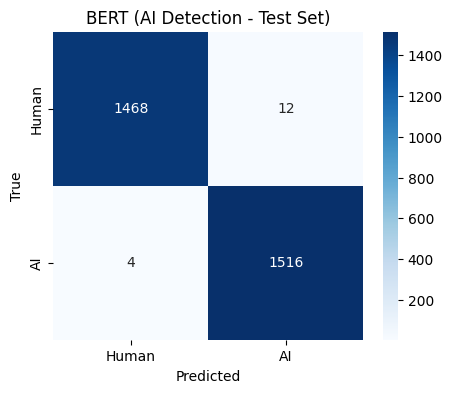


--- Confusion Matrix: DeBERTa ---


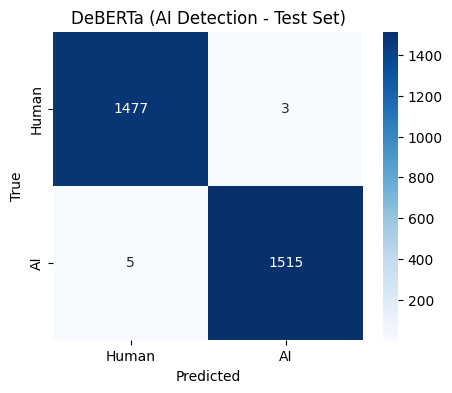

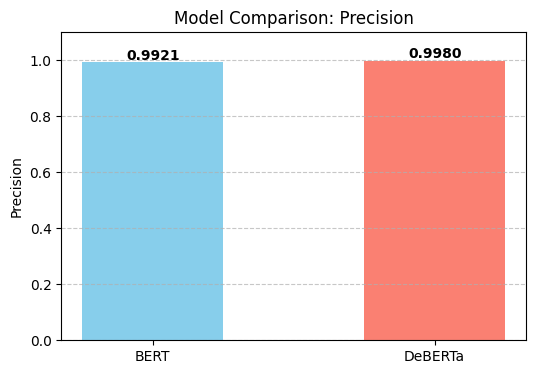

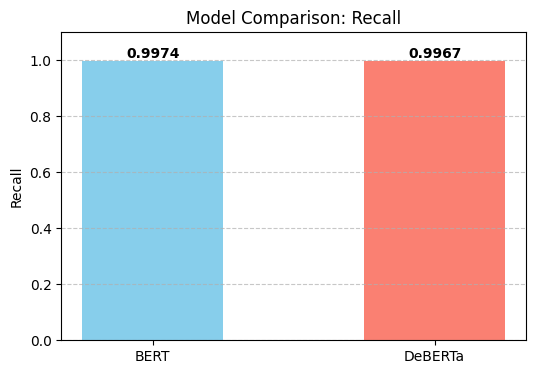

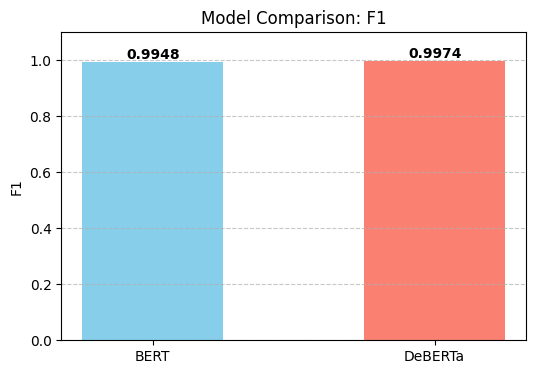

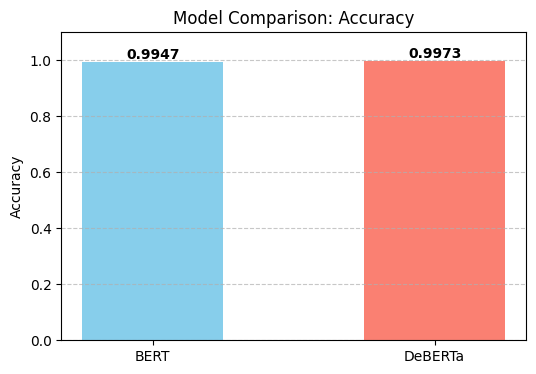

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np
import pandas as pd

summary = {
    "AI_Detection": {
        "bert": {
            "precision": bert_results['eval_precision'],
            "recall": bert_results['eval_recall'],
            "f1": bert_results['eval_f1'],
            "accuracy": bert_results['eval_accuracy']
        },
        "deberta": {
            "precision": deberta_results['eval_precision'],
            "recall": deberta_results['eval_recall'],
            "f1": deberta_results['eval_f1'],
            "accuracy": deberta_results['eval_accuracy']
        }
    }
}

def get_predictions(trainer, tokenized_dataset):
    preds = trainer.predict(tokenized_dataset)
    y_pred = np.argmax(preds.predictions, axis=-1)
    y_true = preds.label_ids
    return y_true, y_pred

print("Fetching predictions for Confusion Matrix...")
y_true_bert, y_pred_bert = get_predictions(trainer_bert, tokenized_bert["test"])
y_true_deb, y_pred_deb = get_predictions(trainer_deberta, tokenized_deberta["test"])

def plot_confusion(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Human', 'AI'], yticklabels=['Human', 'AI'])
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

print("\n--- Confusion Matrix: BERT ---")
plot_confusion(y_true_bert, y_pred_bert, "BERT (AI Detection - Test Set)")

print("\n--- Confusion Matrix: DeBERTa ---")
plot_confusion(y_true_deb, y_pred_deb, "DeBERTa (AI Detection - Test Set)")

metrics = ["precision", "recall", "f1", "accuracy"]
model_names = ["BERT", "DeBERTa"]

for metric in metrics:
    plt.figure(figsize=(6,4))

    values = [summary["AI_Detection"]["bert"][metric],
              summary["AI_Detection"]["deberta"][metric]]

    colors = ['skyblue', 'salmon']
    plt.bar(model_names, values, color=colors, width=0.5)

    for i, v in enumerate(values):
        plt.text(i, v + 0.01, f"{v:.4f}", ha='center', fontweight='bold')

    plt.ylim(0, 1.1)
    plt.ylabel(metric.capitalize())
    plt.title(f"Model Comparison: {metric.capitalize()}")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()